# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve
from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
# Montando uma função bivariada para variáveis qualitativas
def bivariada(df, var_resposta, var_explicativa):
    df_tab = pd.crosstab(df[var_explicativa], df[var_resposta], margins= True, margins_name = 'Total')
    df_tab.loc[df_tab.index[-1],'Média_de_Doentes'] = np.mean(df_tab[1][:-1])
    df_tab['chance'] = df_tab[1]/df_tab[0]
    df_tab['Logito'] = np.log(df_tab['chance'])
    df_tab['RC_vs_Total'] = df_tab['chance']/df_tab.loc['Total','chance']
    df_tab['WOE'] = np.log(df_tab['RC_vs_Total'])
    df_tab.rename({0:'saudáveis',1:'doentes'}, axis=1, inplace=True)
    return df_tab

In [5]:
# Montando uma bivariada para a variável 'cp'
df_tab_cp = bivariada(df, 'flag_doente', 'cp')
df_tab_cp

flag_doente,saudáveis,doentes,Total,Média_de_Doentes,chance,Logito,RC_vs_Total,WOE
cp,,,,,,,,
1.0,16,7,23,NaN,0.437500,-0.826679,0.516187,-0.661286
2.0,41,9,50,NaN,0.219512,-1.516347,0.258993,-1.350955
3.0,68,18,86,NaN,0.264706,-1.329136,0.312315,-1.163743
4.0,39,105,144,NaN,2.692308,0.990399,3.176536,1.155791
Total,164,139,303,34.75,0.847561,-0.165392,1.000000,0.000000


In [6]:
# Montando uma bivariada para a variável 'fbs'
df_tab_fbs = bivariada(df, 'flag_doente', 'fbs')
df_tab_fbs

flag_doente,saudáveis,doentes,Total,Média_de_Doentes,chance,Logito,RC_vs_Total,WOE
fbs,,,,,,,,
0.0,141,117,258,NaN,0.829787,-0.186586,0.979030,-0.021193
1.0,23,22,45,NaN,0.956522,-0.044452,1.128558,0.120941
Total,164,139,303,69.5,0.847561,-0.165392,1.000000,0.000000


In [7]:
# Montando uma bivariada para a variável 'restecg'
df_tab_restecg = bivariada(df, 'flag_doente', 'restecg')
df_tab_restecg

flag_doente,saudáveis,doentes,Total,Média_de_Doentes,chance,Logito,RC_vs_Total,WOE
restecg,,,,,,,,
0.0,95,56,151,NaN,0.589474,-0.528525,0.695494,-0.363133
1.0,1,3,4,NaN,3.000000,1.098612,3.539568,1.264005
2.0,68,80,148,NaN,1.176471,0.162519,1.388066,0.327911
Total,164,139,303,46.333333,0.847561,-0.165392,1.000000,0.000000


#### <span style="color:blue">Análise:</span>
* Das 03 (três) variáveis escolhidas <span style="color:red">__('cp', 'fbs' e 'restecg')__</span>, a **cp** parece discriminar mais o risco tendo em vista que a categoria **4: assintomático** apresentar quase metade dos indivíduos, e com uma chance de **2.69**.

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [8]:
# Montando uma função bivariada para variáveis quantitativas contínuas (com muitas categorias) 
def bivariada_cont(df, var_resposta, var_explicativa):
    var_min = -int(-(df[var_explicativa].min()-1)//1)
    var_max = -int(-(df[var_explicativa].max())//1)
    x = var_min
    z = - int(-((var_max - var_min)/5)//1)
    intervalos = []
    faixas = []
    intervalos.append(x)
    while x < var_max:
        x = x + z
        intervalos.append(x)
    for i in range(0, len(intervalos)-1):
        faixas.append(f"{intervalos[i]} - {intervalos[i + 1]}")
    cat = f'{var_explicativa}' + '_cat'
    df[cat] = pd.cut(df[var_explicativa], bins = intervalos, labels = faixas)
    df_tab = pd.crosstab(df[cat], df[var_resposta], margins= True, margins_name = 'Total')
    df_tab.loc[df_tab.index[-1],'Média_de_Doentes'] = np.mean(df_tab[1][:-1])
    df_tab['chance'] = df_tab[1]/df_tab[0]
    df_tab['Logito'] = np.log(df_tab['chance'])
    df_tab['RC_vs_Total'] = df_tab['chance']/df_tab.loc['Total','chance']
    df_tab['WOE'] = np.log(df_tab['RC_vs_Total'])
    df_tab.rename({0:'saudáveis',1:'doentes'}, axis=1, inplace=True)
    return df_tab

In [9]:
# Montando uma bivariada para a variável 'age'
df_tab_age = bivariada_cont(df, 'flag_doente', 'age')
df_tab_age

flag_doente,saudáveis,doentes,Total,Média_de_Doentes,chance,Logito,RC_vs_Total,WOE
age_cat,,,,,,,,
28 - 38,8,3,11,NaN,0.375000,-0.980829,0.442446,-0.815437
38 - 48,50,21,71,NaN,0.420000,-0.867501,0.495540,-0.702108
48 - 58,63,53,116,NaN,0.841270,-0.172843,0.992577,-0.007450
58 - 68,35,57,92,NaN,1.628571,0.487703,1.921480,0.653096
68 - 78,8,5,13,NaN,0.625000,-0.470004,0.737410,-0.304611
Total,164,139,303,27.8,0.847561,-0.165392,1.000000,0.000000


In [10]:
# Montando uma bivariada para a variável 'trestbps'
df_tab_trestbps = bivariada_cont(df, 'flag_doente', 'trestbps')
df_tab_trestbps

flag_doente,saudáveis,doentes,Total,Média_de_Doentes,chance,Logito,RC_vs_Total,WOE
trestbps_cat,,,,,,,,
93 - 115,32,20,52,NaN,0.625000,-0.470004,0.737410,-0.304611
115 - 137,79,62,141,NaN,0.784810,-0.242313,0.925963,-0.076921
137 - 159,44,40,84,NaN,0.909091,-0.095310,1.072596,0.070082
159 - 181,9,15,24,NaN,1.666667,0.510826,1.966427,0.676218
181 - 203,0,2,2,NaN,inf,inf,inf,inf
Total,164,139,303,27.8,0.847561,-0.165392,1.000000,0.000000


In [11]:
# Montando uma bivariada para a variável 'oldpeak'
df_tab_oldpeak = bivariada_cont(df, 'flag_doente', 'oldpeak')
df_tab_oldpeak

flag_doente,saudáveis,doentes,Total,Média_de_Doentes,chance,Logito,RC_vs_Total,WOE
oldpeak_cat,,,,,,,,
-1 - 1,123,57,180,NaN,0.463415,-0.769133,0.546763,-0.603741
1 - 3,39,64,103,NaN,1.641026,0.495321,1.936174,0.660714
3 - 5,2,16,18,NaN,8.000000,2.079442,9.438849,2.244834
5 - 7,0,2,2,NaN,inf,inf,inf,inf
Total,164,139,303,34.75,0.847561,-0.165392,1.000000,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp``` e com as variáveis quantitativas ```age +  trestbps```.

**Interprete os parâmetros.**

In [12]:
reglog = smf.logit(" flag_doente ~ C(sex) + C(cp) + trestbps + age"
                   , data=df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.3097
Time:                        21:57:15   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(sex)[T.1.0]     1.8094      0.353      5.130      0.000       1.118       2.501
C(cp)[T.2.0]     -0.0617      0.636     -0.097      0.923      -1.309       1.186
C(cp)[T.3.0]      0.0715      0.573      0.125      0.901      -1.051       1.194
C(cp)[T.4.0]      2.4789      0.553      4.485      0.000       1.396       3.562
trestbps          0.0193      0.009      2.261      0.024       0.003       0.036
age               0.0567      0.018      3.120      0.002       0.021       0.092
=================================================================================
"""

#### <span style="color:blue">Análise:</span>
* A variável **cp (Tipo de dor no peito)** diante das demais parece **pouco relevante** para as categorias **2 e 3**;
* Sendo que a categoria **4** da variável **cp** aumenta as chances de doença;
* Os indivíduos de **sexo masculino apresentam maior chance de doença**;
* Aumento na **pressão sanguínea em repouso (trestbps)**, **aumenta** a chance de doença; e
* Há **aumento** de chance de doença com o **aumento da idade**.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [13]:
# Calculando a probabilidade de evento predita segundo o modelo
df['predito'] = reglog.predict(df)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,age_cat,trestbps_cat,oldpeak_cat,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,58 - 68,137 - 159,1 - 3,0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,58 - 68,159 - 181,1 - 3,0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,58 - 68,115 - 137,1 - 3,0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,28 - 38,115 - 137,3 - 5,0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,38 - 48,115 - 137,1 - 3,0.027278


In [14]:
# Categorizando essa probabilidade em G=5 grupos
cat_pred = pd.qcut(df['predito'], 5, duplicates='drop')
cat_pred.value_counts().sort_index()

predito
(0.0131, 0.143]    62
(0.143, 0.287]     59
(0.287, 0.586]     62
(0.586, 0.822]     59
(0.822, 0.944]     61
Name: count, dtype: int64

In [15]:
# Calculando a probabilidade de evento predita média por grupo
group_reg = df.groupby(cat_pred)
qualid = group_reg[['flag_doente']].count().rename(columns = {'flag_doente': 'contagem'})
qualid['predito'] = group_reg['predito'].mean()
qualid

,contagem,predito
predito,,
"(0.0131, 0.143]",62,0.072008
"(0.143, 0.287]",59,0.209626
"(0.287, 0.586]",62,0.435175
"(0.586, 0.822]",59,0.708861
"(0.822, 0.944]",61,0.874819


In [16]:
# Calculando a taxa de eventos (média da variável indicadora de eventos) por grupo
qualid['pct_doente'] = group_reg['flag_doente'].mean()
qualid

,contagem,predito,pct_doente
predito,,,
"(0.0131, 0.143]",62,0.072008,0.080645
"(0.143, 0.287]",59,0.209626,0.152542
"(0.287, 0.586]",62,0.435175,0.483871
"(0.586, 0.822]",59,0.708861,0.762712
"(0.822, 0.944]",61,0.874819,0.819672


Text(0.5, 0, 'Grupo')

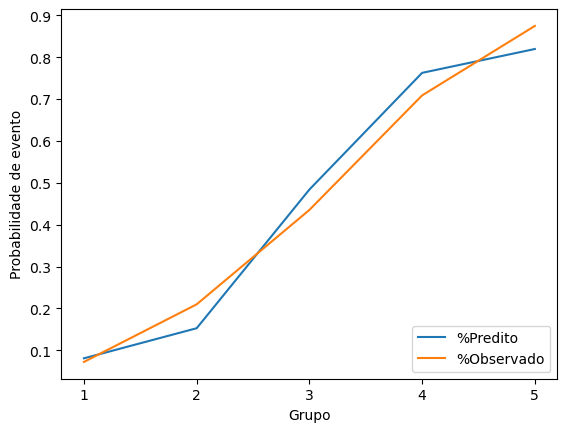

In [17]:
# Comparando graficamente o valor esperado versus observado para a taxa de maus por grupo
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_doente'].plot(label='%Predito')
ax = qualid['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

#### <span style="color:blue">Análise:</span>
* Os valores previstos e observados estão **'conversando'**, ou seja, **há uma boa calibragem**.

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

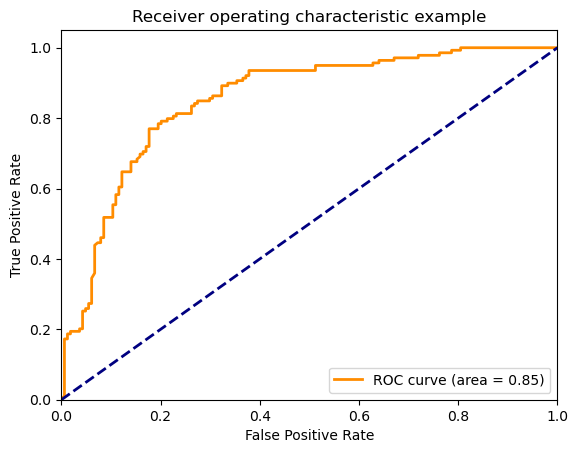

In [18]:
# Visualizando a curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

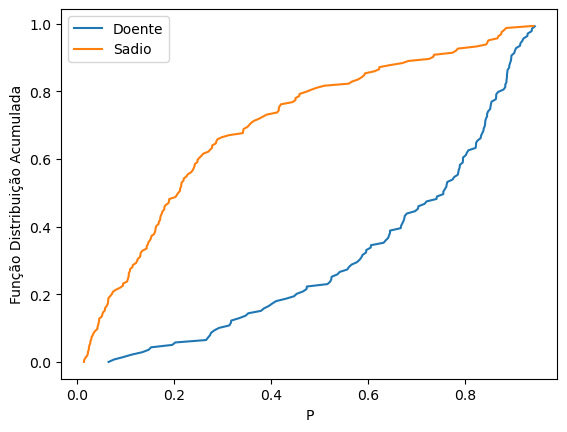

In [19]:
# Visualizando o gráfico KS
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Doente')

score_pop2 = df.loc[df['flag_doente']!=1,'predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Sadio')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

In [20]:
# Calculando acurácia, GINI e KS
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 79.54%
KS: 59.30% 
AUC: 85.19% 
GINI: 70.39%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [21]:
# Gerando o modelo com o acréscimo da variável 'thal'
reglog2 = smf.logit(" flag_doente ~ C(sex) + C(cp) + C(thal)+ trestbps + age"
                   , data=df).fit()

reglog2.summary()

Optimization terminated successfully.
         Current function value: 0.429541
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.3772
Time:                        21:57:52   Log-Likelihood:                -130.15
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 2.252e-29
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -7.6095      1.680     -4.528      0.000     -10.903      -4.316
C(sex)[T.1.0]      1.1711      0.389      3.010      0.003       0.409       1.934
C(cp)[T.2.0]       0.0404      0.665      0.061      0.952      -1.264       1.345
C(cp)[T.3.0]      -0.0242      0.606     -0.040      0.968      -1.211       1.163
C(cp)[T.4.0]       2.1968      0.574      3.826      0.000       1.072       3.322
C(thal)[T.6.0]     0.9836      0.632      1.556      0.120      -0.256       2.223
C(thal)[T.7.0]     1.7666      0.343      5.152      0.000       1.095       2.439
C(thal)[T.?]       1.3736      1.953      0.703      0.482      -2.455       5.202
trestbps           0.0137      0.009      1.534      0.125      -0.004       0.031
age                0.0536      0.019      2.809      0.005       0.016       0.091
==================================================================================
"""

In [22]:
# OBS: Há dois registros deferentes da descrição da base
df['thal'].value_counts()

thal
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64

In [23]:
# Calculando a probabilidade de evento predita segundo o modelo
df['predito2'] = reglog2.predict(df)

df.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,age_cat,trestbps_cat,oldpeak_cat,predito,predito2
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,58 - 68,137 - 159,1 - 3,0.458229,0.476149
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,58 - 68,159 - 181,1 - 3,0.944123,0.823062


In [24]:
# Categorizando essa probabilidade em G=5 grupos
cat_pred2 = pd.qcut(df['predito2'], 5, duplicates='drop')
cat_pred2.value_counts().sort_index()

predito2
(0.013000000000000001, 0.0935]    61
(0.0935, 0.279]                   60
(0.279, 0.565]                    61
(0.565, 0.865]                    60
(0.865, 0.963]                    61
Name: count, dtype: int64

In [25]:
# Calculando a probabilidade de evento predita média por grupo
group_reg2 = df.groupby(cat_pred2)
qualid2 = group_reg2[['flag_doente']].count().rename(columns = {'flag_doente': 'contagem'})
qualid2['predito'] = group_reg2['predito2'].mean()
qualid2

,contagem,predito
predito2,,
"(0.013000000000000001, 0.0935]",61,0.053079
"(0.0935, 0.279]",60,0.161532
"(0.279, 0.565]",61,0.427701
"(0.565, 0.865]",60,0.736969
"(0.865, 0.963]",61,0.914136


In [26]:
# Calculando a taxa de eventos (média da variável indicadora de eventos) por grupo
qualid2['pct_doente'] = group_reg2['flag_doente'].mean()
qualid2

,contagem,predito,pct_doente
predito2,,,
"(0.013000000000000001, 0.0935]",61,0.053079,0.049180
"(0.0935, 0.279]",60,0.161532,0.183333
"(0.279, 0.565]",61,0.427701,0.409836
"(0.565, 0.865]",60,0.736969,0.750000
"(0.865, 0.963]",61,0.914136,0.901639


Text(0.5, 0, 'Grupo')

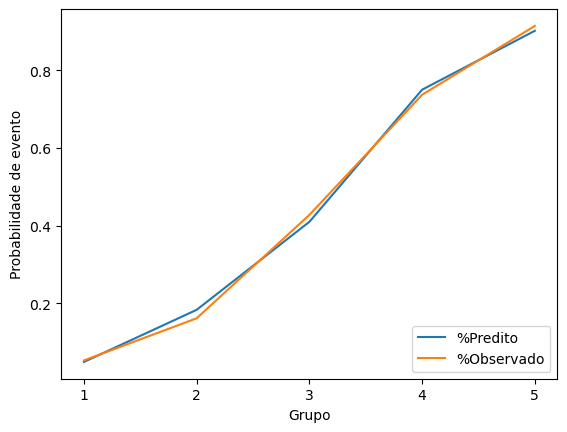

In [27]:
# Comparando graficamente o valor esperado versus observado para a taxa de maus por grupo
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid2['pct_doente'].plot(label='%Predito')
ax = qualid2['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

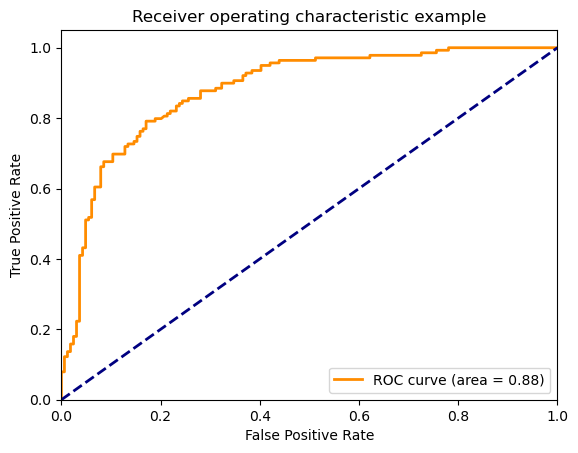

In [28]:
# Visualizando a curva ROC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito2'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito2'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

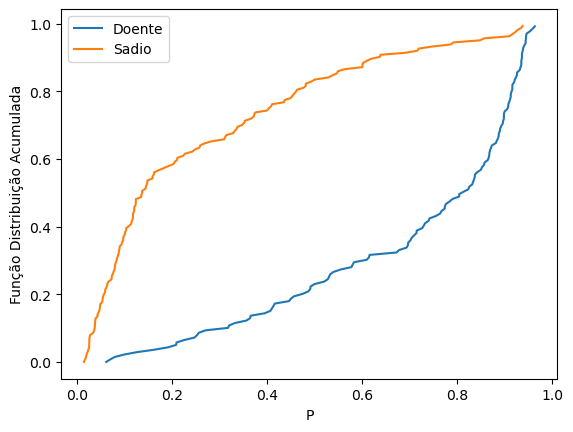

In [29]:
# Visualizando o gráfico KS
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'predito2']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Doente')

score_pop2 = df.loc[df['flag_doente']!=1,'predito2']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Sadio')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

In [30]:
# Calculando acurácia, GINI e KS
acc = metrics.accuracy_score(df['flag_doente'], df['predito2']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito2'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito2'], df.loc[df['flag_doente'] != 1, 'predito2']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 80.53%
KS: 62.06% 
AUC: 88.05% 
GINI: 76.11%


#### <span style="color:blue">Análise:</span>
* Com a inclusão da variável **'thal'** houve melhora:
    - Na Acurácia de 79.54% para 80.53%;
    - No GINI de 70.39% para 76.11%; e
    - No KS de 59,30% para 62,06%.